# Arabic

## Libraries

In [1]:
# for data analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for English NLP
import spacy

# for Arabic lemmatization and diacritization
from farasa.stemmer import FarasaStemmer
from farasa.diacratizer import FarasaDiacritizer

# for NLP
import nltk

# for string manipulation
import re

# for getting translations
# from reverso_api.context import ReversoContextAPI

# for creating anki decks
# import genanki

# generic
from itertools import islice, permutations
from time import sleep
import pickle

ModuleNotFoundError: No module named 'nltk'

## Texts

In [34]:
# load Arabic text
# with open('/home/warehouse/Nextcloud/Books/Arabic/Fiction/Andy Weir - Artemis - ar.txt', 'r') as file:
#     text_ar = file.read()

with open('./Books/Stephen King, Institute.txt', 'r') as file:
    text_ar = file.read()
    
# text_ar = regex.sub(r"\p{P}+", '  ', text_ar)

In [3]:
# load English text
with open('/home/warehouse/Nextcloud/Books/Arabic/Fiction/Andy Weir - Artemis - en.txt', 'r') as file:
    text_en = file.read()
    
# text_en = regex.sub(r"\p{P}+", '  ', text_en)

## Naive approach

In [4]:
# naive approach to textual analysis, devoid of any normalisation
def naive_approach(text):
    # tokenization
    words = text.split()
    words_unique = set(text.split())
    
    # count frequencies of unique lemmas
    freq_list = nltk.FreqDist(words)
    
    # determine coverage of total lemmas by the n most frequent lemmas
    coverage = pd.DataFrame({
        'Lemma': dict(freq_list.most_common()).keys(),
        'Values': dict(freq_list.most_common()).values()
    })
    coverage['Cumulative'] = coverage['Values'].cumsum() / coverage['Values'].sum() * 100
    
    elements = {
        'words': words,
        'words_unique': words_unique,
        'freq_list': freq_list,
        'coverage': coverage,
    }
    
    return elements

### Arabic text

In [5]:
# naive approach applied to Arabic text
naive_approach_ar = naive_approach(text_ar)

words:		 142582 
unique words:	 38156
[('في', 3033), ('على', 2204), ('من', 2167), ('أن', 2159), ('إلى', 1857), ('لا', 1228), ('كان', 911), ('لُوك', 891), ('لكن', 870), ('لم', 870)]
0 0
10 7
20 36
30 128
40 368
50 966
60 2283
70 5114
80 11091
90 23897
100 38156


<AxesSubplot:>

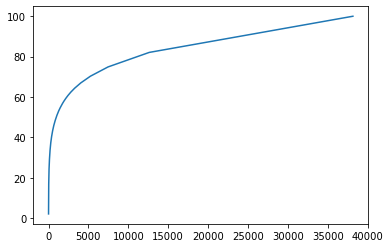

In [6]:
# metrics of naive approach
print(
    'words:\t\t', len(naive_approach_ar['words']),
    '\nunique words:\t', len(naive_approach_ar['words_unique'])
)

print(naive_approach_ar['freq_list'].most_common(10))
    
for i in range(0, 101, 10):
    print(i, sum(naive_approach_ar['coverage']['Cumulative'] <= i))

naive_approach_ar['coverage']['Cumulative'].plot()

### English text

In [11]:
# naive approach applied to English text
naive_approach_en = naive_approach(text_en)

words:		 88311 
unique words:	 14291
[('the', 4080), ('I', 3128), ('to', 2454), ('a', 2254), ('and', 1641), ('of', 1275), ('in', 980), ('my', 909), ('was', 825), ('it', 779)]
0 0
10 2
20 9
30 27
40 69
50 161
60 382
70 896
80 2200
90 5631
100 14291


<AxesSubplot:>

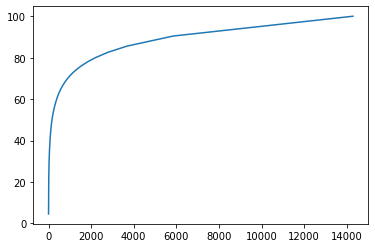

In [12]:
# metrics of naive approach
print(
    'words:\t\t', len(naive_approach_en['words']),
    '\nunique words:\t', len(naive_approach_en['words_unique'])
)

print(naive_approach_en['freq_list'].most_common(10))
    
for i in range(0, 101, 10):
    print(i, sum(naive_approach_en['coverage']['Cumulative'] <= i))

naive_approach_en['coverage']['Cumulative'].plot()

## NLP

Approach:
- load NLP model
- process text
- perform a sanity check
- lemmatize text
- identify unique lemmas
- plot cumulative frequency of unique lemmas
- perform the above analysis without stopwords
- check what tokens have been discarded during the analysis

### English text

#### Unique lemmas

In [13]:
# initiate English NLP model
nlp = spacy.load('en_core_web_md')

In [14]:
# process text
doc = nlp(text_en)

In [16]:
# sanity check to estimate the most frequent tokens that fulfill given criteria
def check_freqs(text, keep):
    condition = lambda token, keep: any([
        token.is_alpha,
        token.is_stop,
        (token.is_oov and not token.is_space)
    ]) if keep else all([
        not token.is_alpha,
        not token.is_digit,
        not token.is_punct,
        not token.is_space,
        not token.is_stop
    ])
    
    freqs = nltk.FreqDist([token.lemma_ for token in doc if condition(token, keep)])
    
    return freqs

In [17]:
# apply sanity check to text
freqs_kept = check_freqs(text_en, True)
freqs_discarded = check_freqs(text_en, False)
print(
    'Kept tokens: {} occurrences from {} tokens\n'.format(
        sum(freqs_kept.values()), len(freqs_kept)
    ),
    freqs_kept.most_common(10),
    '\n\n',
    'Discarded tokens: {} occurrences from {} tokens\n'.format(
        sum(freqs_discarded.values()), len(freqs_discarded)
    ),
    freqs_discarded.most_common(10)
)

Kept tokens: 91736 occurrences from 5995 tokens
 [('I', 4708), ('the', 4636), ('to', 2495), ('be', 2436), ('a', 2377), ('and', 1860), ('it', 1648), ('you', 1346), ('of', 1326), ('he', 1179)] 

 Discarded tokens: 173 occurrences from 95 tokens
 [('Mr.', 18), ('CO2', 10), ('p.m.', 8), ('°', 8), ('a.m.', 7), ('>', 6), ('+', 4), ('ma’am', 4), ('CU12', 3), ('416,922', 3)]


In [18]:
# lemmatization and tokenization
lemmas_en = [
    token.lemma_ for token in doc if (
        token.is_alpha \
        or token.is_stop
        or (token.is_oov and not token.is_space) \
    )
]
len(lemmas_en)

91736

In [19]:
# identify unique lemmas
lemmas_unique_en = set(lemmas_en)
len(lemmas_unique_en)

5995

In [23]:
# count frequencies of unique lemmas across kept lemmas
freq_lemmas_en = nltk.FreqDist(lemmas_en)

In [24]:
# sort in descending order
freq_lemmas_en.most_common(10)

[('I', 4708),
 ('the', 4636),
 ('to', 2495),
 ('be', 2436),
 ('a', 2377),
 ('and', 1860),
 ('it', 1648),
 ('you', 1346),
 ('of', 1326),
 ('he', 1179)]

#### Cumulative frequency

In [205]:
# determine coverage of total lemmas by the n most frequent lemmas
coverage_en = pd.DataFrame({
    'Lemma': dict(freq_lemmas_en.most_common()).keys(),
    'Values': dict(freq_lemmas_en.most_common()).values(),
})

coverage_en['Cumulative'] = coverage_en['Values'].cumsum() / coverage_en['Values'].sum() * 100

0 0
10 1
20 5
30 13
40 28
50 57
60 118
70 241
80 517
90 1302
100 5995


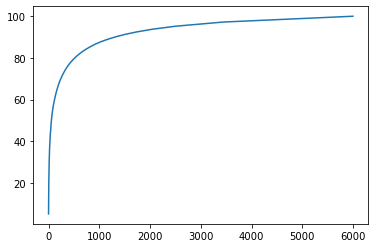

In [207]:
# plot coverage
coverage_en['Cumulative'].plot()

for i in range(0, 101, 10):
    print(i, sum(coverage_en['Cumulative'] <= i))

#### Lemmas not considered

In [71]:
# check discarded tokens to ensure that they are not a large part of the text
def discarded(tokens, lemmas_unique):
#     list conditions for discarding
    conditions = lambda token: all([
        not token.is_alpha,
        not token.is_digit,
        not token.is_punct,
        not token.is_space,
        not token.is_stop
    ])

#     identify unique discarded tokens
    others = [token.lemma_.lower() for token in tokens if conditions(token)]
    others_unique = set(others)
    print(
        'Discarded tokens: {} occurrences from {} tokens\n'.format(
            len(others), len(others_unique)
        )
    )

#     count frequencies of discarded and kept tokens across all tokens
    freq_others = {}
    freq_lemmas = {}
    items = [token.lemma_.lower() for token in tokens]
    
    for other in others_unique:
        freq_others[other] = items.count(other.lower())
    for lemma in lemmas_unique:
        freq_lemmas[lemma] = items.count(lemma.lower())

    print(
        'Total tokens not considered:\t\t{}\nCompared to total tokens considered:\t{:.2%}\n'.format(
            sum(freq_others.values()),
            sum(freq_others.values()) / sum(freq_lemmas.values())
        )
    )

#     sort discarded tokens
    freq_sorted_others = sorted(freq_others, key=freq_others.get, reverse=True)
    print('Most frequent:\n')
    for i in freq_sorted_others:
        print(i, freq_others[i])
        
    return

In [42]:
# determine the discarded tokens
discarded(doc, lemmas_unique_en)

Discarded tokens: 173 occurrences from 92 tokens

Total tokens not considered:		173
Compared to total tokens considered:	0.17%

Discarded tokens:

mr. 18
co2 10
p.m. 8
° 8
a.m. 7
> 6
+ 4
ma’am 4
416,922 3
g. 3
= 3
dr. 3
cu12 3
ms. 2
2:34 2
cd6 2
⅙th 2
you’re 2
1950 2
chang’e 2
that’s 2
2,000ğ 2
cd2 2
j. 2
20.4 2
inc. 2
’cause 2
wait’ll 1
ma’aref 1
1,000,000ğ 1
ncc-1701 1
2.4 1
12,000 1
~100kg 1
8:05 1
75ğ 1
a.m 1
100,000ğ 1
0.4 1
31ğ 1
won’t 1
100ğ 1
200ğ 1
50,000ğ 1
don’t 1
how’d 1
416,922ğ 1
452ğ 1
kovalto1 1
ag-5250 1
1.458 1
12,000ğ 1
they’re 1
11,916ğ 1
1800s 1
der´mo 1
b. 1
10:14 1
© 1
1920s 1
2.5 1
750ğ 1
0.216 1
i’ll 1
mrs. 1
0:00 1
ld7 1
8:00 1
3:17 1
’em 1
ma’alesh 1
isn’t 1
rudy’d 1
m’okay 1
384,000 1
we’re 1
there? 1
10,814ğ 1
d’d 1
10,800ğ 1
crownpublishing.com 1
0.001 1
400,000 1
3,000 1
✕ 1
1,500ğ 1
v5.1 1
i’m 1
585,966 1
85,000ğ 1
21,628ğ 1
o2 1


#### Stopwords

Stopwords: 53686 occurrences of 266 unique stopword lemmas

Most frequent:

I 5.13%
the 5.05%
to 2.72%
be 2.66%
a 2.59%
and 2.03%
it 1.80%
you 1.47%
of 1.45%
he 1.29%


<AxesSubplot:>

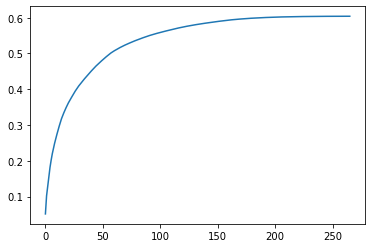

In [132]:
# identify unique stopword lemmas
stopwords_en = [token.lemma_ for token in doc if token.is_stop]
stopwords_unique_en = set(stopwords_en)
print(
    'Stopwords: {} occurrences of {} unique stopword lemmas\n'.format(
        len(stopwords_en),
        len(stopwords_unique_en)
    )
)

# determine frequencies of unique stopwords
freq_stops_en = {}
for stop in stopwords_unique_en:
    freq_stops_en[stop] = freq_lemmas_en[stop] / sum(freq_lemmas_en.values())
    
# sort discarded tokens
freq_sorted_stops_en = sorted(freq_stops_en, key=freq_stops_en.get, reverse=True)
print('Most frequent:\n')
for stop in freq_sorted_stops_en[:10]:
    print(stop, '{:.2%}'.format(freq_stops_en[stop]))

# determine cumulative frequencies
coverage_en = pd.DataFrame({
    'Index': freq_stops_en.keys(),
    'Coverage': freq_stops_en.values()
}).sort_values('Coverage', ascending=False, ignore_index=True)
coverage_en['Cumulative'] = coverage_en['Coverage'].cumsum()

# plot cumulative frequencies
coverage_en['Cumulative'].plot()

Non-stopwords: 36247 occurrences of 5671 unique non-stopword lemmas

Most frequent:

know 0.30%
like 0.28%
right 0.26%
time 0.25%
want 0.24%
look 0.24%
air 0.22%
good 0.22%
Dale 0.20%
work 0.18%


<AxesSubplot:>

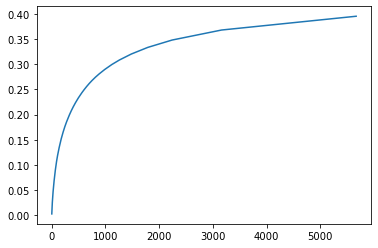

In [133]:
# identify unique non-stopword lemmas
# conditions for non-stopwords lead to some overlap however with stopwords
non_stopwords_en = [
    token.lemma_ for token in doc if (
        token.is_alpha \
        and not token.is_stop \
        and token.lemma_ not in stopwords_en
    )
]
non_stopwords_unique_en = set(non_stopwords_en)
print(
    'Non-stopwords: {} occurrences of {} unique non-stopword lemmas\n'.format(
        len(non_stopwords_en),
        len(non_stopwords_unique_en)
    )
)

# determine frequencies of unique non-stopwords
freq_non_stops_en = {}
for non_stop in non_stopwords_unique_en:
    freq_non_stops_en[non_stop] = freq_lemmas_en[non_stop] / sum(freq_lemmas_en.values())

# sort discarded tokens
freq_sorted_non_stops_en = sorted(freq_non_stops_en, key=freq_non_stops_en.get, reverse=True)
print('Most frequent:\n')
for non_stop in freq_sorted_non_stops_en[:10]:
    print(non_stop, '{:.2%}'.format(freq_non_stops_en[non_stop]))

# determine cumulative frequencies
coverage_non_stop_en = pd.DataFrame({
    'Index': freq_non_stops_en.keys(),
    'Coverage': freq_non_stops_en.values()
}).sort_values('Coverage', ascending=False, ignore_index=True)
coverage_non_stop_en['Cumulative'] = coverage_non_stop_en['Coverage'].cumsum()

# plot cumulative frequencies
coverage_non_stop_en['Cumulative'].plot()

Both stop and non-stop:		0
Neither stop nor non-stop:	3


,Lemma,Freq,Stop,Non-stop
0,I,4708,True,False
1,the,4636,True,False
2,to,2495,True,False
3,be,2436,True,False
4,a,2377,True,False


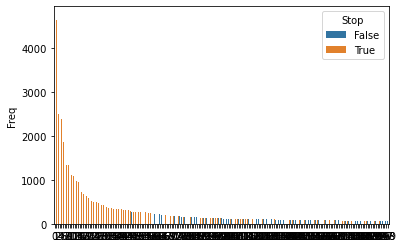

In [160]:
# populate dataframe with lemmas and frequencies
lemmas = pd.DataFrame(freq_lemmas_en.most_common(), columns=['Lemma', 'Freq']).iloc[:2500]
lemmas['Stop'] = lemmas['Lemma'].isin(stopwords_unique_en)
lemmas['Non-stop'] = lemmas['Lemma'].isin(non_stopwords_unique_en)
print(
    'Both stop and non-stop:\t\t{}\nNeither stop nor non-stop:\t{}'.format(
        sum(lemmas['Stop'] & lemmas['Non-stop']),
        sum(~lemmas['Stop'] & ~lemmas['Non-stop'])
    )
)

# plot frequencies of lemmas whether they are stopwords or not
sns.barplot(
    data=lemmas.iloc[:200],
    x=list(range(200)),
    y='Freq',
    hue='Stop',
)

lemmas.head()

### Arabic text

#### Unique lemmas

In [7]:
# initiate Arabic NLP model
stemmer = FarasaStemmer()

In [8]:
# lemmatization
text_stemmed_ar = stemmer.stem(text_ar)

In [9]:
# normalize text by removing diacritics and dealing with different forms of alif
def normalize_ar(token):
    # strip Arabic diacritics
    token = re.compile(r'[\u064B-\u065F]').sub('', token)
    # replace Hamzated Alif with Alif bare
    token = re.compile(r'[\u0622\u0623\u0625]').sub('\u0627', token)
    # replace alifMaqsura with Yaa
    token = re.compile(r'[\u0649]').sub('\u064A', token)
    
    return token

In [10]:
# normalize text by removing diacritics and dealing with different forms of alif
text_stemmed_ar = normalize_ar(text_stemmed_ar)

In [11]:
# sanity check to estimate the most frequent tokens that fulfill given criteria
def check_freqs(tokens, keep):
    condition = lambda token, keep: any([
        token.isalpha()
    ]) if keep else all([
        not token.isalpha(),
        not token.isnumeric(),
        not token.isspace(),
        token.isalnum()
    ])
    
    freqs = nltk.FreqDist([token for token in tokens if condition(token, keep)])
    
    return freqs

In [12]:
# apply sanity check to text
freqs_kept = check_freqs(nltk.wordpunct_tokenize(text_stemmed_ar), True)
freqs_discarded = check_freqs(nltk.wordpunct_tokenize(text_stemmed_ar), False)
print(
    'Kept tokens: {} occurrences from {} tokens\n'.format(
        sum(freqs_kept.values()), len(freqs_kept)
    ),
    freqs_kept.most_common(10),
    '\n\n',
    'Discarded tokens: {} occurrences from {} tokens\n'.format(
        sum(freqs_discarded.values()), len(freqs_discarded)
    ),
    freqs_discarded.most_common(10)
)

Kept tokens: 141456 occurrences from 8753 tokens
 [('ان', 4996), ('في', 3323), ('علي', 2749), ('من', 2716), ('كان', 2649), ('الي', 2126), ('هذا', 1926), ('لا', 1901), ('لكن', 1608), ('قال', 1552)] 

 Discarded tokens: 8 occurrences from 6 tokens
 [('940NF', 2), ('HK37', 2), ('37s', 1), ('x49ger194GbL4', 1), ('AC6000CW', 1), ('P238S', 1)]


In [13]:
# tokenization of lemmas
lemmas_ar = [token for token in nltk.wordpunct_tokenize(text_stemmed_ar) if token.isalpha()]
len(lemmas_ar)

141456

In [14]:
# identify unique lemmas
lemmas_unique_ar = set(lemmas_ar)
len(lemmas_unique_ar)

8753

In [15]:
# count frequencies of unique lemmas across kept lemmas
freq_lemmas_ar = nltk.FreqDist(lemmas_ar)

# pickle frequencies of unique lemmas
with open('freq_lemmas_ar.pkl', 'wb') as file:
    pickle.dump(freq_lemmas_ar, file)

In [16]:
# sort in descending order
freq_lemmas_ar.most_common(10)

[('ان', 4996),
 ('في', 3323),
 ('علي', 2749),
 ('من', 2716),
 ('كان', 2649),
 ('الي', 2126),
 ('هذا', 1926),
 ('لا', 1901),
 ('لكن', 1608),
 ('قال', 1552)]

#### Cumulative frequency

In [17]:
# determine coverage of total lemmas by the n most frequent lemmas
coverage_ar = pd.DataFrame({
    'Lemma': dict(freq_lemmas_ar.most_common()).keys(),
    'Values': dict(freq_lemmas_ar.most_common()).values(),
})

coverage_ar['Cumulative'] = coverage_ar['Values'].cumsum() / coverage_ar['Values'].sum() * 100

In [33]:
coverage_ar[120:135]

,Index,Coverage,Cumulative
120,اثنان,0.000311,0.383144
121,عشرون,0.000311,0.383455
122,تم,0.000297,0.383752
123,جميع,0.000290,0.384042
124,ال,0.000276,0.384317
125,سوي,0.000276,0.384593
126,اجل,0.000269,0.384862
127,ظل,0.000262,0.385123
128,عام,0.000262,0.385385
129,ايا,0.000254,0.385639


0 0
10 4
20 11
30 31
40 67
50 134
60 263
70 504
80 982
90 2179
100 8753


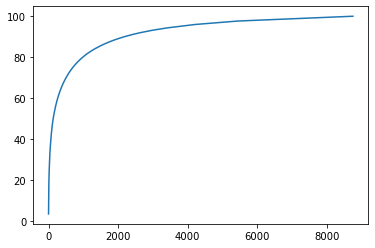

In [18]:
# plot coverage
coverage_ar['Cumulative'].plot()

for i in range(0, 101, 10):
    print(i, sum(coverage_ar['Cumulative'] <= i))

#### Lemmas not considered

In [19]:
# check discarded tokens to ensure that they are not a large part of the text
def discarded(tokens, lemmas_unique):
#     list conditions for discarding
    conditions = lambda token: all([
        not token.isalpha(),
        not token.isnumeric(),
        not token.isspace(),
        token.isalnum()
    ])

#     identify unique discarded tokens
    others = [token for token in tokens if conditions(token)]
    others_unique = set(others)
    print(
        'Discarded tokens: {} occurrences from {} tokens\n'.format(
            len(others), len(others_unique)
        )
    )

#     count frequencies of discarded and kept tokens across all tokens
    freq_others = {}
    freq_lemmas = {}

    for other in others_unique:
        freq_others[other] = tokens.count(other)
    for lemma in lemmas_unique:
        freq_lemmas[lemma] = tokens.count(lemma)

    print(
        'Total tokens not considered:\t\t{}\nCompared to total tokens considered:\t{:.2%}\n'.format(
            sum(freq_others.values()),
            sum(freq_others.values()) / sum(freq_lemmas.values())
        )
    )
    
#     sort discarded tokens
    freq_sorted_others = sorted(freq_others, key=freq_others.get, reverse=True)
    print('Most frequent:\n')
    for i in freq_sorted_others:
        print(i, freq_others[i])
    
    return

In [20]:
# determine the discarded tokens
discarded(nltk.wordpunct_tokenize(text_stemmed_ar), lemmas_unique_ar)

Discarded tokens: 8 occurrences from 6 tokens

Total tokens not considered:		8
Compared to total tokens considered:	0.01%

Most frequent:

940NF 2
HK37 2
x49ger194GbL4 1
37s 1
AC6000CW 1
P238S 1


#### Stopwords

In [22]:
# load list of Arabic stopwords
with open('stopwords.txt', 'r') as file:
    stopwords_all_ar = file.read()
    
# normalise the stopwords through dediacritization
stopwords_all_ar = normalize_ar(stopwords_all_ar)

Stopwords: 751 occurrences of 673 unique stopword lemmas

Most frequent:

ان 
	3.53%
في 
	2.35%
علي 
	1.94%
من 
	1.92%
كان 
	1.87%
الي 
	1.50%
هذا 
	1.36%
لا 
	1.34%
لكن 
	1.14%
قال 
	1.10%


<AxesSubplot:>

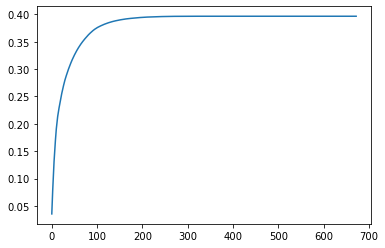

In [23]:
# identify unique stopword lemmas
stopwords_ar = [token for token in stopwords_all_ar.split() if token.isalpha()]
stopwords_unique_ar = set(stopwords_ar)
print(
    'Stopwords: {} occurrences of {} unique stopword lemmas\n'.format(
        len(stopwords_ar),
        len(stopwords_unique_ar)
    )
)

# determine frequencies
freq_stops_ar = {}
for stop in stopwords_unique_ar:
    try:
        freq_stops_ar[stop] = freq_lemmas_ar[stop] / sum(freq_lemmas_ar.values())
    except:
        print(stop)
        continue
        
# sort discarded tokens
freq_sorted_stops_ar = sorted(freq_stops_ar, key=freq_stops_ar.get, reverse=True)
print('Most frequent:\n')
for stop in freq_sorted_stops_ar[:10]:
    print(stop, '\n\t{:.2%}'.format(freq_stops_ar[stop]))
    
# determine cumulative frequencies
coverage_ar = pd.DataFrame({
    'Index': freq_stops_ar.keys(),
    'Coverage': freq_stops_ar.values()
}).sort_values('Coverage', ascending=False, ignore_index=True)
coverage_ar['Cumulative'] = coverage_ar['Coverage'].cumsum()

# plot cumulative frequencies
coverage_ar['Cumulative'].plot()

Non-stopwords: 85367 occurrences of 8456 unique non-stopword lemmas

Most frequent:

لوك 0.99%
اخر 0.55%
بدا 0.53%
شيء 0.50%
عرف 0.48%
ولد 0.47%
امكن 0.46%
يا 0.41%
تيم 0.39%
سيد 0.37%


<AxesSubplot:>

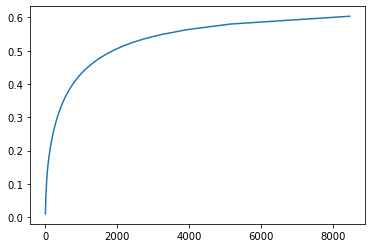

In [24]:
# identify unique non-stopword lemmas
# conditions for non-stopwords lead to some overlap however with stopwords
non_stopwords_ar = [
    token for token in nltk.wordpunct_tokenize(text_stemmed_ar) if (
        token.isalpha() \
        and token not in stopwords_unique_ar
    )
]
non_stopwords_unique_ar = set(non_stopwords_ar)
print(
    'Non-stopwords: {} occurrences of {} unique non-stopword lemmas\n'.format(
        len(non_stopwords_ar),
        len(non_stopwords_unique_ar)
    )
)

# determine frequencies
freq_non_stops_ar = {}
for non_stop in non_stopwords_unique_ar:
    freq_non_stops_ar[non_stop] = freq_lemmas_ar[non_stop] / sum(freq_lemmas_ar.values())
    
# sort discarded tokens
freq_sorted_non_stops_ar = sorted(freq_non_stops_ar, key=freq_non_stops_ar.get, reverse=True)
print('Most frequent:\n')
for non_stop in freq_sorted_non_stops_ar[:10]:
    print(non_stop, '{:.2%}'.format(freq_non_stops_ar[non_stop]))

# determine cumulative frequency
coverage_non_stop_ar = pd.DataFrame({
    'Index': freq_non_stops_ar.keys(),
    'Coverage': freq_non_stops_ar.values()
}).sort_values('Coverage', ascending=False, ignore_index=True)
coverage_non_stop_ar['Cumulative'] = coverage_non_stop_ar['Coverage'].cumsum()

# plot cumulative frequencies
coverage_non_stop_ar['Cumulative'].plot()

Both stop and non-stop:		0
Neither stop nor non-stop:	0


,Lemma,Freq,Stop,Non-stop
0,ان,4996,True,False
1,في,3323,True,False
2,علي,2749,True,False
3,من,2716,True,False
4,كان,2649,True,False


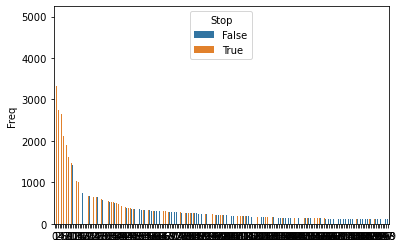

In [25]:
# populate dataframe with lemmas and frequencies
lemmas = pd.DataFrame(freq_lemmas_ar.most_common(), columns=['Lemma', 'Freq']).iloc[:2500]
lemmas['Stop'] = lemmas['Lemma'].isin(stopwords_unique_ar)
lemmas['Non-stop'] = lemmas['Lemma'].isin(non_stopwords_unique_ar)
print(
    'Both stop and non-stop:\t\t{}\nNeither stop nor non-stop:\t{}'.format(
        sum(lemmas['Stop'] & lemmas['Non-stop']),
        sum(~lemmas['Stop'] & ~lemmas['Non-stop'])
    )
)

# plot frequencies of lemmas whether they are stopwords or not
sns.barplot(
    data=lemmas.iloc[:200],
    x=list(range(200)),
    y='Freq',
    hue='Stop',
)

lemmas.head()

## Online sentences and translations

### Frequency list and functions

In [14]:
# load Arabic frequency list from text
with open('freq_lemmas_ar.pkl', 'rb') as file:
    freq_lemmas_ar = pickle.load(file)

In [15]:
# normalize text by removing diacritics and dealing with different forms of alif
def normalize_ar(token):
    # strip Arabic diacritics
    token = re.compile(r'[\u064B-\u065F]').sub('', token)
    # replace Hamzated Alif with Alif bare
    token = re.compile(r'[\u0622\u0623\u0625]').sub('\u0627', token)
    # replace alifMaqsura with Yaa
    token = re.compile(r'[\u0649]').sub('\u064A', token)
    
    return token

In [9]:
# keep only the first token from every row of a frequency list that is not from text
def normalize_freq_list(freq_list):
    keys = freq_list\
        .apply(normalize_ar)\
        .apply(lambda x: re.sub(r'^\W+', '', x))\
        .apply(lambda x: re.sub(r'\W+.*', '', x))\
        .drop_duplicates()\
        .reset_index(drop=True)
    
    freq_list = {
        key: len(keys) - index for index, key in keys.iteritems()
    }
    
    return freq_list

In [250]:
# load Arabic frequency list (not from text)
freq_list_full_ar = pd.read_csv('Anki decks/freqlist.csv', header=0)
    
freq_list_ar = normalize_freq_list(freq_list_full_ar['Arabic'])

freq_list_ar

{'الـ': 4569,
 'و': 4568,
 'في': 4567,
 'من': 4566,
 'لـ': 4565,
 'بـ': 4564,
 'علي': 4563,
 'ان': 4562,
 'الي': 4561,
 'كان': 4560,
 'لا': 4559,
 'الله': 4558,
 'عن': 4557,
 'قال': 4556,
 'هذا': 4555,
 'مع': 4554,
 'التي': 4553,
 'كل': 4552,
 'هو': 4551,
 'فـ': 4550,
 'هذه': 4549,
 'او': 4548,
 'الذي': 4547,
 'انا': 4546,
 'يوم': 4545,
 'لم': 4544,
 'ما': 4543,
 'بين': 4542,
 'هي': 4541,
 'بعد': 4540,
 'يا': 4539,
 'ذلك': 4538,
 'قد': 4537,
 'اخر': 4536,
 'شيء': 4535,
 'عند': 4534,
 'اول': 4533,
 'غير': 4532,
 'اذا': 4531,
 'نفس': 4530,
 'عربي': 4529,
 'اي': 4528,
 'رئيس': 4527,
 'عمل': 4526,
 'عرف': 4525,
 'بعض': 4524,
 'دولة': 4523,
 'كما': 4522,
 'الا': 4521,
 'انت': 4520,
 'كثير': 4519,
 'واحد': 4518,
 'لان': 4517,
 'لكن': 4516,
 'ليس': 4515,
 'جديد': 4514,
 'عام': 4513,
 'احد': 4512,
 'اكثر': 4511,
 'كبير': 4510,
 'اخ': 4509,
 'كيف': 4508,
 'قبل': 4507,
 'سنة': 4506,
 'امر': 4505,
 'قوة': 4504,
 'هل': 4503,
 'خلال': 4502,
 'مرة': 4501,
 'راي': 4500,
 'اب': 4499,
 'هناك': 4498,
 '

### Reverso

#### API functions

In [326]:
# get translations and example sentences from reverso
def reverso(word):
    try:
        api = ReversoContextAPI(
            source_text=word,
            source_lang='ar',
            target_lang='en'
        )

        translations = []
        for i in islice(api.get_translations(), 10):
#             try:
            translations.append(i)
#             except Exception as ex:
#                 print(
#                     'error\t\t\t\t\t\t\treverso translations:\t',
#                     repr(ex)
#                 )
#                 sleep(10)
#                 translations.append(i) 

        examples = []
        for i in islice(api.get_examples(), 10):
#             try:
            examples.append(i)
#             except Exception as ex:
#                 print(
#                     'error\t\t\t\t\t\t\treverso examples:\t',
#                     repr(ex)
#                 )
#                 sleep(10)
#                 examples.append(i)

        result = {
            'translations': translations,
            'examples': examples
        }
    
    except Exception as ex:
        print(
            'error\t\t\t\t\t\t\treverso:\t',
            repr(ex)
        )
        sleep(10)
        result = reverso(word)
    
    return result

In [327]:
# iterate over lemmas and deal with connection errors
def api_calls(freq_list_translations, freq_list, n):
    try:
        keys = list(freq_list.keys())[n:]
        for word in keys:
#             try:
            freq_list_translations[word] = reverso(word)
#             except Exception as ex:
#                 print(
#                     'error\t\t\t\t\t\t\tapi_calls for:\t',
#                     repr(ex)
#                 )
#                 sleep(10)
#                 freq_list_translations[word] = reverso(word)
            print(n, word)
            n += 1
    except Exception as ex:
        print(
            'error\t\t\t\t\t\t\tapi_calls:\t',
            repr(ex)
        )
        sleep(10)
        freq_list_translations = api_calls(freq_list_translations, n)
    
    return freq_list_translations

#### Getting translations and example sentences from Reverso

In [379]:
# list of lemmas to get sentences for
freq_list = dict(freq_lemmas_ar.most_common(2500))
print(len(freq_list))

# remove any lemmas that already have translations
for i in set(freq_list.keys()).intersection(set(freq_list_translations.keys())):
    freq_list.pop(i)
print(len(freq_list))

2500
0


In [315]:
# get translations and examples for each lemma in freq_list
freq_list_translations = api_calls(freq_list_translations, freq_list, 0)

0 ان
1 الي
2 امر
3 انا
4 اي
5 اذا
6 اخر
7 لدي
8 اراد
9 ارض
10 انت
11 اب
12 احد
13 اجل
14 امام
15 او
16 ارتميس
17 اكثر
18 راي
19 حتي
20 سال
21 اوكسجين
22 اخذ
23 امكن
24 تاكيد
25 عني
26 افضل
27 راس
28 المنيوم
29 اقل
30 ماوي
31 اول
32 ايض
33 اربع
34 امسك
35 اغلق
36 اوه
37 اتي
38 اخرج
39 الف
40 احب
41 اخير
42 اسفل
43 اسطوانة
44 ادار
45 اخبر
46 ارتدي
47 الدرين
48 امن
49 اشار
50 انبوب
51 انتهي
52 ارجح
53 اكبر
54 اين
55 شوي
56 اعلي
57 الا
58 كفي
59 اعطي
60 تاكد
61 القي
62 مدي
63 ام
64 اطلاق
65 اما
66 اشول
67 ارمسترونغ
68 اكمل
69 اسرع
70 مراة
71 اعاد
72 اه
73 اردف
74 اوما
75 اثر
76 اعلم
77 اوبلاسيو
78 الكتروني
79 ادني
80 اصبع
81 اشر
82 ارضية
83 انذار
84 تمني
85 ارسل
86 اعد
87 شان
88 اضاف
89 ابد
90 الهي
91 الم
92 الفاريز
93 اولائك
94 امان
95 اذن
96 سمي
97 متاكد
98 انهي
99 اقرب
100 اطلق
101 ايري
102 ارسال
103 اضافة
104 اقصي
105 احمر
106 احكم
107 مستوي
108 اسبوع
109 امراة
110 منشاة
111 اسف
112 ملا
113 غطي
114 اصاب
115 انتاج
116 قضي
117 ابعد
118 امل
119 انترنت
120 اوكسيد
121 اعادة
122 كاس
123 اسيت

In [381]:
# check that freq_list_translations has covered unique lemmas
print(
    'freq_list: {}\nfreq_list_translations: {}\nEqual: {}\nDifference: {} {}'.format(
        len(dict(freq_lemmas_ar.most_common(2500))),
        len(freq_list_translations),
        set(freq_list_translations.keys()) == set(dict(freq_lemmas_ar.most_common(2500)).keys()),
        len(set(dict(freq_lemmas_ar.most_common(2500)).keys()).difference(set(freq_list_translations.keys()))),
        len(set(freq_list_translations.keys()).difference(set(dict(freq_lemmas_ar.most_common(2500)).keys())))
    )
)

freq_list: 2500
freq_list_translations: 2500
Equal: True
Difference: 0 0


In [408]:
# pickle reverso translations
with open('translations_reverso.pkl', 'wb') as file:
    pickle.dump(freq_list_translations, file)

#### Scoring sentences

In [3]:
# load reverso translations
with open('translations_reverso.pkl', 'rb') as file:
    freq_list_translations = pickle.load(file)

In [57]:
# check the sentences
sentences = []
translations = []

for key, value in freq_list_translations.items():
    for item in value['examples']:
        sentences.append(item[0].text)
        translations.append(item[1].text)
        
sentences = pd.DataFrame({
    'text_source': sentences,
    'text_target': translations
})

sentences.drop_duplicates(
    'text_source',
    keep='first',
    inplace=True,
    ignore_index=True
)

sentences.drop_duplicates(
    'text_target',
    keep='first',
    inplace=True,
    ignore_index=True
)

sentences.sort_values('text_source')

,text_source,text_target
2305,""" يتدفّق منه ماء الذهب والفضّة واللازورد""!","It flows with water of gold, silver, and lapis..."
17689,"""... كل عصر له مسيح""",'every era has a messiah...'
23326,""".تكون هنا لجمال و أناقة لغة الأُرديّة""","""Here's to the beauty and elegance of Urdu..."""
865,"""Eyeballing"" هي الطريقة الأكثر شيوعًا والمتاحة...","""Eyeballing"" is the most common and readily av..."
8540,"""آسفه من طلب"" كونج بآو","Sorry, who had the kung pao?"
...,...,...
9983,٩ - السيدة سمولسك)أوروغواي(: تحدثت، باسم مقدمي...,"Ms. Smolcic (Uruguay) said, on behalf of the s..."
6467,٩- وتشيد اللجنة بالتدابير القانونية وادارية ال...,The Committee commends the legal and administr...
14823,٩-٣١ واهداف في مجال استثمار هي:,9.13 In the area of investment the objectives ...
21856,٩٤ - ويسمح اختيار نظام اتصال مع الساتل بالتشغي...,Selection of an uplink system allows for fully...


In [25]:
# initiate Arabic NLP model
# stemmer in interactive mode to increase speed when iterating
stemmer = FarasaStemmer(interactive=True)

[2021-02-12 19:22:25,767 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [26]:
# function that scores sentences based on how common their lemmas are
def score_sentence(sentence, freq_lemmas_ar):
    score = 0
    lemmas = 0
    
    sentence_normalized = normalize_ar(stemmer.stem(sentence))
    sentence_lemmas = [token for token in nltk.wordpunct_tokenize(sentence_normalized) if token.isalpha()]
    
    for lemma in sentence_lemmas:
        try:
            score += freq_lemmas_ar[lemma]
            lemmas += 1
        except:
            continue
            
    score = score / lemmas / len(sentence_lemmas) * 100
            
    return score

In [27]:
# check the scoring function
word = list(dict(freq_lemmas_ar.most_common(2500)).keys())[10]
print(word)

sentence = freq_list_translations[word]['examples']
for ar, en in sentence:
    print(
        ar.text,
        '\n\t\t\t',
        score_sentence(ar.text, freq_lemmas_ar),
        '\n\t\t\t',
        en.text,
        '\n'
    )
   

ذلك
الباب الخلفي Johnnies، أو ما شابه ذلك ذلك الرجلِ الغريبِ بالتوقيعِ الكتاب يَدْعو نفسه. 
			 1310.204081632653 
			 The stage-door Johnnies, or whatever that strange man with the autograph book calls himself. 

أنا يَجِبُ أَنْ أُعالجَ ذلك عندما أَنا خلفيُ في Ilaria. 
			 6000.0 
			 I'll have to remedy that once I'm back at Ilaria. 

لقد استحقيت ذلك ولكن أريدكِ أن تدركِ ذلك 
			 7656.25 
			 I have earned it, but I want you to know it. 

العاملون يشجعون ذلك ويقفون بينما يحدث ذلك 
			 3151.0204081632655 
			 The staff encourages it and stand by while it happens. 

الساحرات والقمر لديهم ذلك الاتفاق ذلك الاتصال 
			 3375.5102040816328 
			 Witches and the moon they have this deal, this connection. 

ذلك شخص ما سرق المفاتيح للإقتحام نظام ترشيح بركة جيمي Castigan. 
			 1204.9586776859503 
			 That somebody stole the keys to break into Jimmy Castigan's pool filtration system. 

إصدارها الأخير ذلك العام كان فيلم Madhoshi بجانب جون أبراهام. 
			 2255.0 
			 Her final release that year was A

In [28]:
# iterate over sentences, scoring and translating each
def score_translate_sentences(freq_list_translations, freq_lemmas_ar):
    sentences = {}

    for lemma in freq_list_translations:
        examples = freq_list_translations[lemma]['examples']
        for sentence_ar, sentence_en in examples:
            sentences[sentence_ar.text] = {
                'translation': sentence_en.text,
                'score': score_sentence(sentence_ar.text, freq_lemmas_ar)
            }

    return sentences

In [29]:
# score sentences
sentences = score_translate_sentences(freq_list_translations, freq_lemmas_ar)

In [30]:
# check best scoring sentences
sentences_sorted = sorted(sentences, key=lambda x: sentences[x]['score'], reverse=True)
for i in sentences_sorted[:10]:
    print(
        '{}\n{}\n'.format(
        i,
        sentences[i]
        )
    )

إنها لا تزحزح.
{'translation': "It won't budge.", 'score': 33522.222222222226}

هذا يَكُونُ جيزمو.
{'translation': 'That would be Gizmo over here.', 'score': 26677.777777777777}

من الذى شهق ؟
{'translation': "Who's sniffling?", 'score': 25011.111111111113}

ملتف في داخلك...
{'translation': 'Coiled inside you.', 'score': 24522.22222222222}

الآن، الطبيب مجيء في إلى...
{'translation': 'Now, the doctor is coming in to...', 'score': 22248.0}

عبس من الصلب.
{'translation': 'Abs of steel.', 'score': 20844.444444444445}

كيفما تريدين أنْ أكون، سأكون.
{'translation': "however you want me to be, i'll be.", 'score': 20748.0}

ليس الآن، ليس الآن، ليس الآن
{'translation': 'Not now, not now, not now.', 'score': 20066.666666666664}

قلت أنه سعل رئه
{'translation': 'You said he coughed up a lung.', 'score': 19068.75}

لقد ظننت أنك أشول
{'translation': 'i thought you were left handed.', 'score': 17600.0}



In [31]:
# pickle reverso sentences
with open('sentences_reverso.pkl', 'wb') as file:
    pickle.dump(sentences, file)

### Tatoeba

#### Getting sentences from Tatoeba

In [87]:
# load the dataset from Tatoeba's downloads page
sentences_all = pd.read_csv(
    'Sentences/sentences.csv',
    delimiter='\t',
    header=None,
    names=['id', 'lang', 'text']
)

links = pd.read_csv(
    'Sentences/links.csv',
    delimiter='\t',
    header=None,
    names=['id', 'translation_id']
)

reviews = pd.read_csv(
    'Sentences/users_sentences.csv',
    delimiter='\t',
    header=None,
    names=[
        'username',
        'id',
        'review',
        'added',
        'modified'
    ]
)

# check dataframes' shape
print(
    'Shapes:',
    '\nsentences', sentences_all.shape,
    '\nlinks', links.shape,
    '\nreviews', reviews.shape
)

Shapes: 
sentences (9289126, 3) 
links (18977846, 2) 
reviews (1166067, 5)


In [88]:
# select sentences in either eng or ara
sentences_ara_eng = sentences_all[sentences_all['lang'].isin(['ara', 'eng'])]

print(
    'Shape:', sentences_ara_eng.shape,
    '\n\nValue counts:\n',
    sentences_ara_eng['lang'].value_counts()
)

sentences_ara_eng.head()

Shape: (1460909, 3) 

Value counts:
 eng    1425300
ara      35609
Name: lang, dtype: int64


,id,lang,text
1232,1276,eng,Let's try something.
1233,1277,eng,I have to go to sleep.
1235,1280,eng,Today is June 18th and it is Muiriel's birthday!
1236,1282,eng,Muiriel is 20 now.
1237,1283,eng,"The password is ""Muiriel""."


In [254]:
# ensure that 'links' dataframe is bidirectional
print(
    all(links['id'].value_counts() == links['translation_id'].value_counts())
)

links.head()

True


,id,translation_id
0,1,1276
1,1,2481
2,1,5350
3,1,5972
4,1,180624


In [89]:
# determine average scores
reviews_id = reviews.groupby('id', as_index=False).agg({
    'review': 'mean'
})

reviews_id[reviews_id['review'] < 0]

,id,review
30,585,-1.0
961,3115,-1.0
1269,5669,-1.0
1271,5672,-1.0
1273,5678,-1.0
...,...,...
1157247,9712825,-1.0
1157248,9712828,-1.0
1157601,9721774,-1.0
1157603,9721778,-1.0


In [90]:
# select inter-related sentences that are either 'ara' or 'eng', and add scores
sentences_translations = links.merge(
    sentences_ara_eng,
    how='inner',
    on='id'
) \
.merge(
    sentences_ara_eng,
    how='inner',
    left_on='translation_id',
    right_on='id',
    suffixes=('_source', '_target')
) \
.drop(columns=['translation_id'])

sentences_translations

,id_source,lang_source,text_source,id_target,lang_target,text_target
0,1276,eng,Let's try something.,392773,ara,لنجرب فعل شيءٍ ما.
1,1276,eng,Let's try something.,461821,ara,لنجرب شيئاً!
2,1277,eng,I have to go to sleep.,372962,ara,عليّ أن أنام.
3,1277,eng,I have to go to sleep.,383342,ara,عليّ الذهاب إلى النوم.
4,1395,eng,I have to go to bed.,383342,ara,عليّ الذهاب إلى النوم.
...,...,...,...,...,...,...
294193,9729424,eng,I thought you already had one of those.,9729425,eng,I thought that you already had one of those.
294194,9729425,eng,I thought that you already had one of those.,9729424,eng,I thought you already had one of those.
294195,9729427,eng,I thought Tom might be mad at you.,9729428,eng,I thought that Tom might be mad at you.
294196,9729428,eng,I thought that Tom might be mad at you.,9729427,eng,I thought Tom might be mad at you.


In [91]:
# add review information for source and target
sentences_scores = sentences_translations.merge(
    reviews_id,
    how='left',
    left_on='id_source',
    right_on='id'
) \
.merge(
    reviews_id,
    how='left',
    left_on='id_target',
    right_on='id',
    suffixes=('_score_source', '_score_target')
) \
.drop(columns=['id_score_source', 'id_score_target']) \
.fillna(0)

sentences_scores

,id_source,lang_source,text_source,id_target,lang_target,text_target,review_score_source,review_score_target
0,1276,eng,Let's try something.,392773,ara,لنجرب فعل شيءٍ ما.,1.0,0.0
1,1276,eng,Let's try something.,461821,ara,لنجرب شيئاً!,1.0,0.0
2,1277,eng,I have to go to sleep.,372962,ara,عليّ أن أنام.,1.0,0.0
3,1277,eng,I have to go to sleep.,383342,ara,عليّ الذهاب إلى النوم.,1.0,0.0
4,1395,eng,I have to go to bed.,383342,ara,عليّ الذهاب إلى النوم.,1.0,0.0
...,...,...,...,...,...,...,...,...
294193,9729424,eng,I thought you already had one of those.,9729425,eng,I thought that you already had one of those.,1.0,0.0
294194,9729425,eng,I thought that you already had one of those.,9729424,eng,I thought you already had one of those.,0.0,1.0
294195,9729427,eng,I thought Tom might be mad at you.,9729428,eng,I thought that Tom might be mad at you.,0.0,0.0
294196,9729428,eng,I thought that Tom might be mad at you.,9729427,eng,I thought Tom might be mad at you.,0.0,0.0


In [92]:
# select only sentences are 'ara' to 'eng' and have positive scores, then remove 'ara' duplicates
# 'eng' duplicates will be dropped in the next section
sentences_ara = sentences_scores[
    (
        (sentences_scores['lang_source'] == 'ara') 
        & (sentences_scores['lang_target'] == 'eng')
    ) & (
        (sentences_scores['review_score_source'] >= 0)
        & (sentences_scores['review_score_target'] > 0)
    )
].sort_values(
    ['review_score_source', 'review_score_target'],
    ascending=False
).drop_duplicates(
    ['id_source'],
    keep='first'
).sort_values(
    'id_target',
    ignore_index=True
)

sentences_ara

,id_source,lang_source,text_source,id_target,lang_target,text_target,review_score_source,review_score_target
0,392773,ara,لنجرب فعل شيءٍ ما.,1276,eng,Let's try something.,0.0,1.0
1,461821,ara,لنجرب شيئاً!,1276,eng,Let's try something.,0.0,1.0
2,383342,ara,عليّ الذهاب إلى النوم.,1277,eng,I have to go to sleep.,0.0,1.0
3,7960374,ara,لازم أنام.,1277,eng,I have to go to sleep.,0.0,1.0
4,372962,ara,عليّ أن أنام.,1277,eng,I have to go to sleep.,0.0,1.0
...,...,...,...,...,...,...,...,...
14507,9640524,ara,كل ما نحن بحاجة إليه هو خطة.,9640522,eng,All we need is a plan.,0.0,1.0
14508,6009369,ara,كان عليك أن تكون قد بدأت الآن.,9684702,eng,You should've started by now.,0.0,1.0
14509,416582,ara,أنت مجرد طالب.,9684756,eng,You're nothing but a student.,0.0,1.0
14510,794485,ara,ليس بمقدوري إنهاء العمل قبل حلول الغد.,9694274,eng,I can't possibly finish the work by tomorrow.,0.0,1.0


#### Removing duplicates

In [93]:
# initiate Arabic NLP model
# stemmer in interactive mode to increase speed when iterating
stemmer = FarasaStemmer(interactive=True)

[2021-02-20 10:43:57,855 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [94]:
# identify sentences with identical translations
duplicates = sentences_ara[sentences_ara.duplicated('id_target', keep=False)]

print(len(duplicates))
duplicates.head()

3523


,id_source,lang_source,text_source,id_target,lang_target,text_target,review_score_source,review_score_target
0,392773,ara,لنجرب فعل شيءٍ ما.,1276,eng,Let's try something.,0.0,1.0
1,461821,ara,لنجرب شيئاً!,1276,eng,Let's try something.,0.0,1.0
2,383342,ara,عليّ الذهاب إلى النوم.,1277,eng,I have to go to sleep.,0.0,1.0
3,7960374,ara,لازم أنام.,1277,eng,I have to go to sleep.,0.0,1.0
4,372962,ara,عليّ أن أنام.,1277,eng,I have to go to sleep.,0.0,1.0


In [95]:
# lemmatize, normalize, and tokenize sentences for comparison

for index, row in duplicates.iterrows():
    sentence_normalized = normalize_ar(stemmer.stem(row['text_source']))
    sentence_lemmas = [token for token in nltk.wordpunct_tokenize(sentence_normalized) if token.isalpha()]
    duplicates.loc[index, 'lemmas_source'] = {'_': sentence_lemmas}.values()
        
print(len(duplicates))
duplicates.head()

/home/warehouse/miniconda3/envs/arabic/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/warehouse/miniconda3/envs/arabic/lib/python3.8/site-packages/pandas/core/indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


3523


,id_source,lang_source,text_source,id_target,lang_target,text_target,review_score_source,review_score_target,lemmas_source
0,392773,ara,لنجرب فعل شيءٍ ما.,1276,eng,Let's try something.,0.0,1.0,"[جرب, فعل, شيء, ما]"
1,461821,ara,لنجرب شيئاً!,1276,eng,Let's try something.,0.0,1.0,"[جرب, شيء]"
2,383342,ara,عليّ الذهاب إلى النوم.,1277,eng,I have to go to sleep.,0.0,1.0,"[علي, ذهاب, الي, نوم]"
3,7960374,ara,لازم أنام.,1277,eng,I have to go to sleep.,0.0,1.0,"[لازم, انام]"
4,372962,ara,عليّ أن أنام.,1277,eng,I have to go to sleep.,0.0,1.0,"[علي, ان, انام]"


In [98]:
# check overlap between lemmas of duplicate sentences
redundant_all = set()

for i in duplicates['id_target'].unique():
    duplicate_sentences = duplicates[duplicates['id_target'] == i]
    redundant = set()

#     if lemmas of sentence are included in lemmas of another, get the index
    for j in permutations(duplicate_sentences.index, 2):
        difference = set(duplicates.loc[j[0], 'lemmas_source']).difference(
            set(duplicates.loc[j[1], 'lemmas_source'])
        )
        if not difference:
            redundant.add(j[0])
    
#     if all sentences for specific translation are redundant, remove one from 'redundant'
    if set(duplicate_sentences.index) == redundant:
        redundant.pop()
        
    redundant_all = redundant_all.union(redundant)
            
len(set(redundant_all))

584

In [99]:
# check redundant duplicate sentences
duplicates[duplicates.index.isin(redundant_all)]

,id_source,lang_source,text_source,id_target,lang_target,text_target,review_score_source,review_score_target,lemmas_source
1,461821,ara,لنجرب شيئاً!,1276,eng,Let's try something.,0.0,1.0,"[جرب, شيء]"
9,400781,ara,سأعود قريباً.,1284,eng,I will be back soon.,0.0,1.0,"[عاد, قريب]"
10,549596,ara,سأعود بعد قليل.,1284,eng,I will be back soon.,0.0,1.0,"[عاد, بعد, قليل]"
21,461824,ara,كنت في الجبال.,1290,eng,I was in the mountains.,0.0,1.0,"[كان, في, جبل]"
23,434091,ara,هل هذه صورة حديثة؟,1291,eng,Is it a recent picture?,0.0,1.0,"[هل, هذا, صورة, حديث]"
...,...,...,...,...,...,...,...,...,...
14330,8182024,ara,لا أصدق أن توم هو القاتل.,8182022,eng,I don't believe that Tom is the killer.,0.0,1.0,"[لا, اصدق, ان, توم, هو, قاتل]"
14382,8636665,ara,أحب قطتكم.,8636533,eng,I love your cat.,0.0,1.0,"[احب, قط]"
14383,8636661,ara,أحب قطتك.,8636533,eng,I love your cat.,0.0,1.0,"[احب, قط]"
14385,8636660,ara,أحب قطك.,8636533,eng,I love your cat.,0.0,1.0,"[احب, قط]"


In [100]:
# drop redundant duplicate sentences
index_drop = duplicates[duplicates.index.isin(redundant_all)].index
sentences_ara.drop(index=index_drop, inplace=True)

sentences_ara

,id_source,lang_source,text_source,id_target,lang_target,text_target,review_score_source,review_score_target
0,392773,ara,لنجرب فعل شيءٍ ما.,1276,eng,Let's try something.,0.0,1.0
2,383342,ara,عليّ الذهاب إلى النوم.,1277,eng,I have to go to sleep.,0.0,1.0
3,7960374,ara,لازم أنام.,1277,eng,I have to go to sleep.,0.0,1.0
4,372962,ara,عليّ أن أنام.,1277,eng,I have to go to sleep.,0.0,1.0
5,407539,ara,اليوم هو الثامن عشر من يونيو و هو عيد ميلاد مو...,1280,eng,Today is June 18th and it is Muiriel's birthday!,0.0,1.0
...,...,...,...,...,...,...,...,...
14507,9640524,ara,كل ما نحن بحاجة إليه هو خطة.,9640522,eng,All we need is a plan.,0.0,1.0
14508,6009369,ara,كان عليك أن تكون قد بدأت الآن.,9684702,eng,You should've started by now.,0.0,1.0
14509,416582,ara,أنت مجرد طالب.,9684756,eng,You're nothing but a student.,0.0,1.0
14510,794485,ara,ليس بمقدوري إنهاء العمل قبل حلول الغد.,9694274,eng,I can't possibly finish the work by tomorrow.,0.0,1.0


In [101]:
# pickle freq_list_translations
with open('translations_tatoeba.pkl', 'wb') as file:
    pickle.dump(sentences_ara, file)

#### Scoring sentences

In [23]:
# load tatoeba translations
with open('translations_tatoeba.pkl', 'rb') as file:
    sentences_ara = pickle.load(file)

In [3]:
# initiate Arabic NLP model
# stemmer in interactive mode to increase speed when iterating
stemmer = FarasaStemmer(interactive=True)

[2021-02-20 13:57:22,385 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [28]:
# function that scores sentences based on how common their lemmas are
def score_sentence(sentence, freq_lemmas_ar):
    score = 0
    lemmas = 0
    
    sentence_normalized = normalize_ar(stemmer.stem(sentence))
    sentence_lemmas = [token for token in nltk.wordpunct_tokenize(sentence_normalized) if token.isalpha()]
    
    for lemma in sentence_lemmas:
        try:
            score += freq_lemmas_ar[lemma]
            lemmas += 1
        except:
            continue
            
    score = score / lemmas / len(sentence_lemmas) * 100
            
    return score

In [29]:
# check the scoring function
sentence = sentences_ara.iloc[30]
print(sentence)

score_sentence(sentence['text_source'], freq_lemmas_ar)

id_source                               392776
lang_source                                ara
text_source            سيكلفك ذلك ثلاثين يورو.
id_target                                 1298
lang_target                                eng
text_target                This will cost €30.
review_score_source                        0.0
review_score_target                        1.0
Name: 36, dtype: object


4137.5

In [30]:
# iterate over sentences, scoring and translating each
def score_translate_sentences(sentences_ara, freq_lemmas_ar):
    sentences = {}

    for index, row in sentences_ara.iterrows():
        sentences[row['text_source']] = {
            'translation': row['text_target'],
            'score': score_sentence(row['text_source'], freq_lemmas_ar)
        }
    
    return sentences

In [19]:
# score sentences
sentences = score_translate_sentences(sentences_ara, freq_lemmas_ar)

In [108]:
# load diactritization model
diacritizer = FarasaDiacritizer(interactive=True)

[2021-02-20 10:46:15,011 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [109]:
# diacritize sentences
sentences = {diacritizer.diacritize(key): value for key, value in sentences.items()}

In [110]:
# check correlation between length of sentences and score
# longer sentences have higher scores, because of how score is calculated
sentences_ara['score_source'] = pd.NA

for index, text in sentences_ara['text_source'].iteritems():
    sentences_ara.loc[index, 'score_source'] = sentences[text]['score']
    
x = sentences_ara[
    sentences_ara.duplicated(
        'id_target',
        keep=False
    )
].copy()

x['len'] = x['text_source'].apply(len)

x.sort_values(
    ['id_target', 'len', 'score_source'],
    ascending=False,
    inplace=True
)
x = x.where(
    x['score_source']/x['score_source'].max() >= 0
).dropna()

fig = plt.figure(figsize=(10, 10))

x1 = x.drop_duplicates('id_target', keep='first')

ax1 = fig.add_subplot(221)
sns.histplot(
    data=x1['len']/x['len'].max(),
    color='red',
    label='len',
    ax=ax1
)
sns.histplot(
    x1['score_source']/x['score_source'].max(),
    color='blue',
    label='score',
    ax=ax1
)
ax1.set_title('keep longest sentences')
ax1.legend()

x2 = x.drop_duplicates('id_target', keep='last')

ax2 = fig.add_subplot(222)
sns.histplot(
    data=x2['len']/x['len'].max(),
    color='red',
    label='len',
    ax=ax2
)
sns.histplot(
    x2['score_source']/x['score_source'].max(),
    color='blue',
    label='score',
    ax=ax2
)
ax2.set_title('keep shortest sentences')
ax2.legend()

ax3 = fig.add_subplot(223)
sns.scatterplot(
    data=x,
    x='len',
    y='score_source',
    ax=ax3
)

KeyError: 'لنجرب فعل شيءٍ ما.'

In [20]:
# check best scoring sentences
sentences_sorted = sorted(sentences, key=lambda x: sentences[x]['score'], reverse=True)
for i in sentences_sorted[:10]:
    print(
        '{}\n{}\n'.format(
        i,
        sentences[i]
        )
    )

مَن؟
{'translation': 'Who is it?', 'score': 348568900.0}

من؟
{'translation': 'Who?', 'score': 348568900.0}

انهِ هذا.
{'translation': 'Finish this.', 'score': 123071650.0}

أنا في 19
{'translation': "I'm 19.", 'score': 113784325.0}

إنّهما معي.
{'translation': "They're with me.", 'score': 110173050.0}

أفكر فيك.
{'translation': "I'm thinking about you.", 'score': 110084200.0}

في صحتك.
{'translation': 'Cheers!', 'score': 110040500.0}

إنّي أبوك.
{'translation': 'I am your father.', 'score': 108848125.0}

إننا رجال.
{'translation': 'We are men.', 'score': 108342250.0}

إنها جديدة.
{'translation': "It's brand new.", 'score': 108164925.0}



In [112]:
# pickle tatoeba sentences
with open('sentences_tatoeba.pkl', 'wb') as file:
    pickle.dump(sentences, file)

## Anki deck generation

### Sentences

In [114]:
# load reverso sentences
with open('sentences_reverso.pkl', 'rb') as file:
    sentences_reverso = pickle.load(file)
    
# for i in range(len(sentences_reverso) - 20):
#     sentences_reverso.popitem()
print(len(sentences_reverso))
# sentences_reverso

23636


In [115]:
# load tatoeba sentences
with open('sentences_tatoeba.pkl', 'rb') as file:
    sentences_tatoeba = pickle.load(file)
    
# for i in range(len(sentences_tatoeba) - 20):
#     sentences_tatoeba.popitem()
print(len(sentences_tatoeba))
# sentences_tatoeba

13924


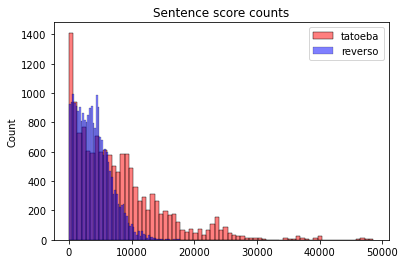

In [121]:
fig, ax = plt.subplots()

sns.histplot(
    [sentences_tatoeba[i]['score'] for i in sentences_tatoeba if sentences_tatoeba[i]['score'] < 50000],
    color='red',
    label='tatoeba',
    alpha=.5,
    ax=ax
)

sns.histplot(
    [sentences_reverso[i]['score'] for i in sentences_reverso if sentences_reverso[i]['score'] < 50000],
    color='blue',
    label='reverso',
    alpha=.5,
    ax=ax
)

ax.set_title('Sentence score counts')
ax.legend()

### Card model

In [122]:
# create random model id
np.random.randint(1<<30, 1<<31)

1772895860

In [123]:
arabic_format = '''
<div style="padding: 5%; background-color: lightgray; color: black">
    <div id=arabic style="text-align: center; vertical-align: middle; direction: rtl; color: DarkRed"> 
        {{Arabic}} 
    </div>
    <br>
    {{#Synonyms}}
        (&ne; {{Synonyms}})
    {{/Synonyms}}
</div>

{{hint::Mnemonic}}
'''

english_format = '''
<div style="padding: 5%; background-color: lightgray; color: black">
    <div id=arabic style="text-align: center; vertical-align: middle; direction: rtl; color: DarkRed"> 
        {{Arabic}} 
    </div>
    <br>
    {{#Synonyms}}
        (&ne; {{Synonyms}})
    {{/Synonyms}}
</div>

<hr id=answer>

<div  id=english style='padding:5%; vertical-align: top; background-color:lightgreen; color:black'> 
    {{English}}
</div>

<hr>

<div style="padding:5%;font-size: small; font-weight: regular; direction: ltr;background-color:lightgreen;color:black;">
    <div id='lemmas' style="text-align: justify ; font-weight: regular; direction: rtl"> 
        {{Lemmas}}
    </div>
</div>

<hr>

<div  style="padding-right:10%;padding-left:10%;text-align: justify ; font-size: small; font-weight: regular; direction: ltr;"> 
    | Score: {{Score}} <br> 
    | Mnemonic: {{Mnemonic}}
</div>
'''

css = '''
.card {
    font-family: Arial;
    font-size: x-large;
    text-align: center;
}
#arabic {
    font-family: Noto Sans Arabic UI Lt;
    font-size: xxx-large
}
#english {
    font-family: Noto Sans;
    font-size: xx-large;
    text-align: center;
    vertical-align: middle;
    color: black;
}
#lemmas {
    font-family: Noto Sans Arabic UI Lt;
    font-size: xx-large;
}
'''

In [124]:
# create deck model
sentence_model = genanki.Model(
    model_id=1886263227,
    name='Arabic',
    fields=[
        {'name': 'Score'},
        {'name': 'Arabic', 'rtl': True},
        {'name': 'English'},
        {'name': 'Mnemonic'},
        {'name': 'Synonyms'},
        {'name': 'Lemmas', 'rtl': True}
    ],
    templates=[
        {
            'score': '{{Score}}',
            'name': 'Card',
            'qfmt': arabic_format,
            'afmt': english_format
        }
    ],
    css=css
)

### Reverso

In [42]:
# create reverso deck
deck_reverso = genanki.Deck(
    1177887818,
    'Arabic: Reverso'
)

In [43]:
# build deck
for sentence in sentences_reverso:
    translation = sentences_reverso[sentence]['translation']
    score = int(sentences_reverso[sentence]['score'])
#     if score < 200:
#         continue
    
    card = genanki.Note(
        model=sentence_model,
        fields=[
            str(score),
            sentence,
            translation,
            '',
            '',
            ''
        ]
    )
    deck_reverso.add_note(card)

In [44]:
# save deck
genanki.Package(deck_reverso).write_to_file('deck_reverso.apkg')

### Tatoeba

In [125]:
# create tatoeba deck
deck_tatoeba = genanki.Deck(
    1667002487,
    'Arabic: Tatoeba'
)

In [126]:
# build deck
for sentence in sentences_tatoeba:
    translation = sentences_tatoeba[sentence]['translation']
    score = int(sentences_tatoeba[sentence]['score'])
#     if score < 200:
#         continue
    
    card = genanki.Note(
        model=sentence_model,
        fields=[
            str(score),
            sentence,
            translation,
            '',
            '',
            ''
        ]
    )
    deck_tatoeba.add_note(card)

In [127]:
# save deck
genanki.Package(deck_tatoeba).write_to_file('deck_tatoeba.apkg')